# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data used was provided by Udacity partners at Bertelsmann Arvato Analytics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold 

from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt import space_eval

from scipy.stats import skew

from mlens.ensemble import SuperLearner
import pickle

import helper as t

#for reproducibility
SEED=42

%matplotlib inline

/Users/bmsbm/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
[MLENS] backend: threading


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', dtype = {18: 'str', 19: 'str'}, sep=';')

Using the file with the mapping of data values for each feature, I created a csv file of features and the corresponding values for missing values. I then pulled the `feat_info.csv` file from the work done in the first term, and combined it with this file to create a data dictionary, which I saved as `AZDIAS_Feature_Summary.csv`. 

I use this data dictionary to make decisions in this project.

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";", index_col=0)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("The general dataset has {} rows and {} columns".format(azdias.shape[0], azdias.shape[1]))
print("The summary dataset has {} rows and {} columns".format(feat_info.shape[0], feat_info.shape[1]))

The general dataset has 891221 rows and 366 columns
The summary dataset has 374 rows and 4 columns


In [5]:
display(azdias.head(5))

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
display(feat_info.head(5))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [16]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


The feature summary file contains a summary of properties for each demographics data column. I use this file to make cleaning decisions during this stage of the project. 

The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. As such, some parsing is needed in order to identify missing values and clean the data.

To do this, I create a new "missing_or_unknown" column, with the string values converted to integers where appropriate.

There are some attributes which are found in the data dictionary, but not in the original dataset, and vice versa. Those attributes found in the dataset but not in the dictionary pose a particular problem, because I wouldn't be able to tell which values correspond to missing values in the data. While compiling the data dictionary, I looked for similar variables in the existing dictionary, and assumed that the missing values were also similar. For example, I assumed that all the variables of the type `D19` were similar, in type and level of information, and that the missing values were also similar.

For the features in the data dictionary which are not found in the dataset, I will drop them from the data dictionary.

In [4]:
feat_info = t.clean_data_dictionary(feat_info, azdias)

I want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing. To do this, I will count the number of 'NAs' in the dataset before and after replacing the missing codes. The difference between these values is the number of encoded missing values.

In [8]:
natural_missing_values = azdias.isnull().sum().sum()
print("The number of naturally missing data points is ", natural_missing_values)

The number of naturally missing data points is  33492923


Now I replace all the missing values in the original dataset, and see what proportion of the missing data was natural

In [9]:
t.replace_missing_values(azdias, feat_info)

In [10]:
total_missing_values = azdias.isnull().sum().sum()
encoded_missing_values = total_missing_values - natural_missing_values
print("There were {} encoded missing values in the dataset, which represents {}% of the total number of missing values in the dataset"
      .format(encoded_missing_values, round(encoded_missing_values/total_missing_values *100, 2)))

There were 28841309 encoded missing values in the dataset, which represents 46.27% of the total number of missing values in the dataset


####  Assess Missing Data in Each Column

Here I assess the number of missing data points in each column of the dataset.

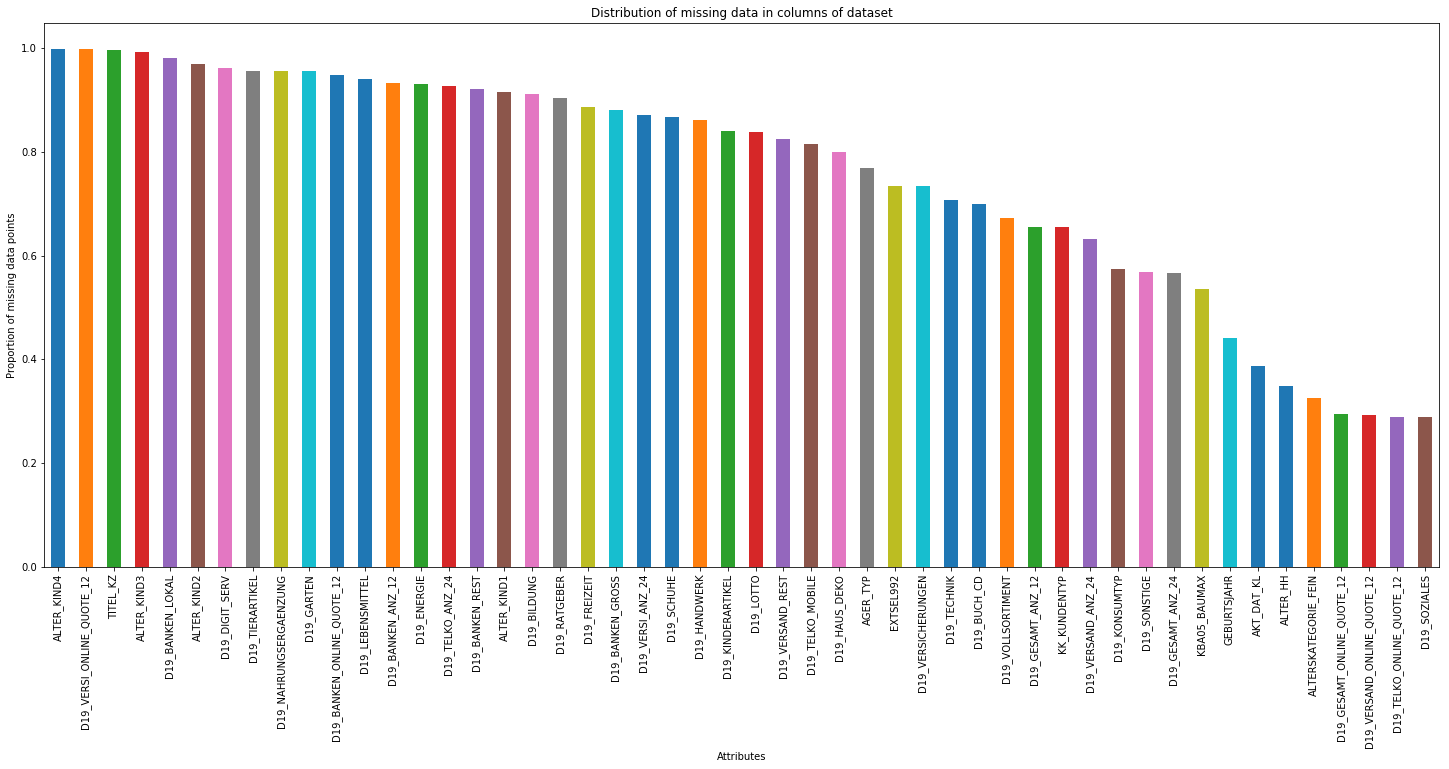

In [11]:
t.show_dist_missing_values_column(azdias)

I will eliminate any column which has more than 30% of missing data points.

In [12]:
n_missing_column_data = azdias.isnull().sum(axis=0).sort_values(ascending=False)

prop_missing_column_data = n_missing_column_data/azdias.shape[0]

columns_to_drop = list(n_missing_column_data[prop_missing_column_data >=0.3].index.values)

print(columns_to_drop)

['ALTER_KIND4', 'D19_VERSI_ONLINE_QUOTE_12', 'TITEL_KZ', 'ALTER_KIND3', 'D19_BANKEN_LOKAL', 'ALTER_KIND2', 'D19_DIGIT_SERV', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_LEBENSMITTEL', 'D19_BANKEN_ANZ_12', 'D19_ENERGIE', 'D19_TELKO_ANZ_24', 'D19_BANKEN_REST', 'ALTER_KIND1', 'D19_BILDUNG', 'D19_RATGEBER', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_VERSI_ANZ_24', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_KINDERARTIKEL', 'D19_LOTTO', 'D19_VERSAND_REST', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'AGER_TYP', 'EXTSEL992', 'D19_VERSICHERUNGEN', 'D19_TECHNIK', 'D19_BUCH_CD', 'D19_VOLLSORTIMENT', 'D19_GESAMT_ANZ_12', 'KK_KUNDENTYP', 'D19_VERSAND_ANZ_24', 'D19_KONSUMTYP', 'D19_SONSTIGE', 'D19_GESAMT_ANZ_24', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN']


In [13]:
azdias_reduced = azdias.drop(columns_to_drop, axis=1)

I found that the data which represented similar features, but on different scales, tended to have similar amounts of missing data. For example  `CAMEO_DEU_2015`, `CAMEO_DEUG_2015`, and `CAMEO_INTL_2015`, which are data on wealth/lifestyle topology on a rough, detailed and international scale respectively, have almost the same amount of missing data.

The columns with lots of missing data tended to be those of individual records, like people's titles, dates of birth, ageing, etc.

#### Step 1.1.3: Assess Missing Data in Each Row

I now do the same for the rows in the dataset.

In [14]:
# How much data is missing in each row of the dataset?
n_missing_row_data = azdias_reduced.isnull().sum(axis=1)

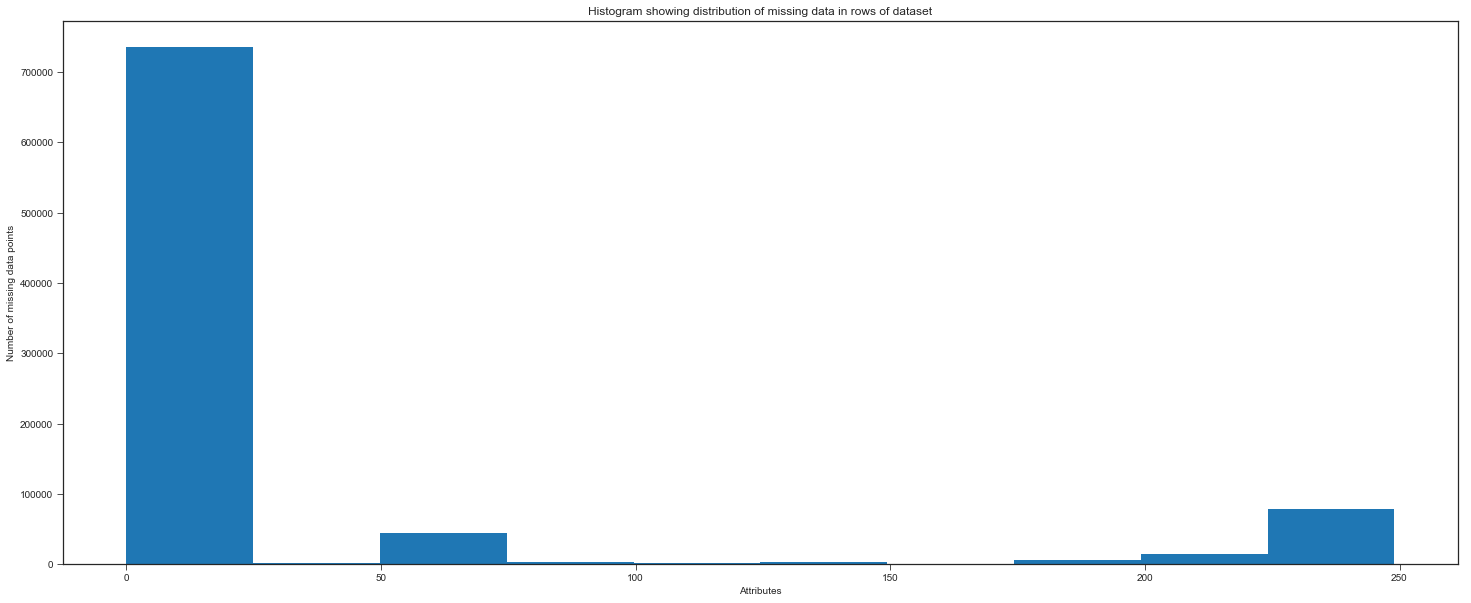

In [15]:
# Investigate patterns in the amount of missing data in each row.
fig = plt.figure(figsize=(25,10))
sns.set_style("ticks")
ax = n_missing_row_data.plot.hist()
ax.set_title("Histogram showing distribution of missing data in rows of dataset")
ax.set_xlabel("Attributes")
ax.set_ylabel("Number of missing data points")
plt.show()

In [16]:
n_missing_row_data.describe()

count    891221.000000
mean         33.345054
std          74.936148
min           0.000000
25%           0.000000
50%           2.000000
75%           7.000000
max         249.000000
dtype: float64

Now I divide the dataset into two subsets based on the number of missing values in each row. The first dataset is comprised of rows with fewer than 25 missing values, while the second dataset contains the rest of the datapoints.

In [17]:
i=25
rows_wo_missing_values = list(np.where(n_missing_row_data <=i)[0])
rows_with_missing_values = list(np.where(n_missing_row_data >i)[0])

azdias_few_missing_values = azdias_reduced.loc[rows_wo_missing_values, :]
azdias_many_missing_values = azdias_reduced.loc[rows_with_missing_values, :]

Now I compare the distribution of values for five columns where there are no or few missing values, between the two subsets.

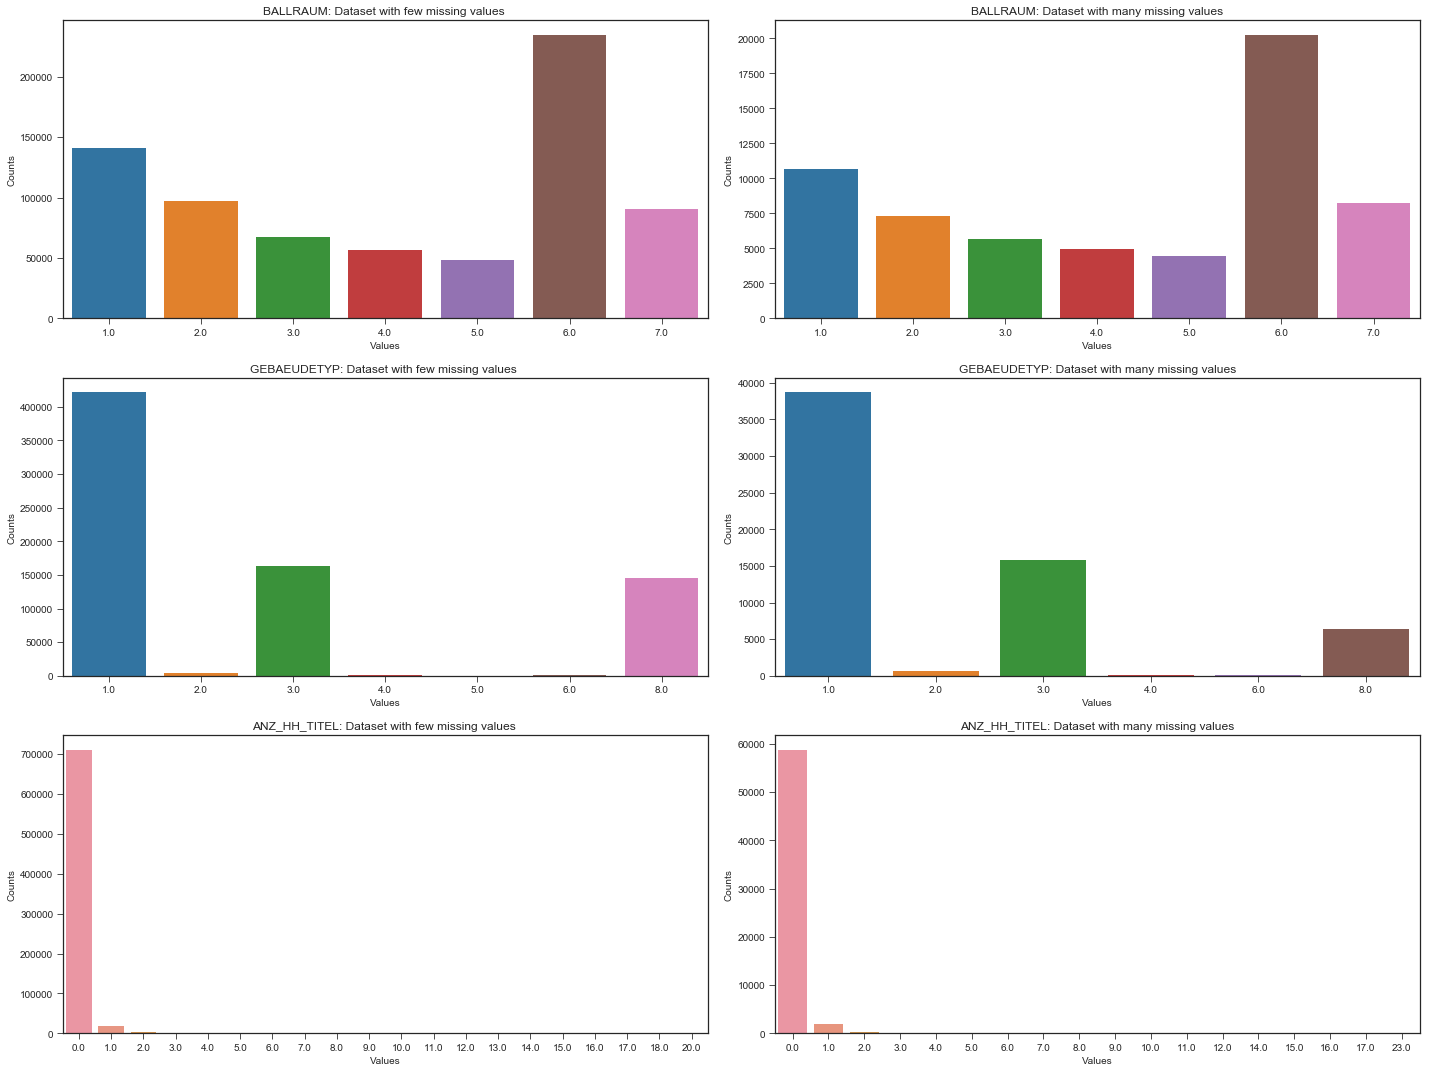

In [18]:
t.compare_distribution(['BALLRAUM', 'GEBAEUDETYP', 'ANZ_HH_TITEL'], 
                       azdias_few_missing_values, 
                       azdias_many_missing_values,
                       "Dataset with few missing values",
                       "Dataset with many missing values"
                      )

From the bar charts above, the distributions of values between both datasets are quite similar. As such, from now on, I will use the dataset with few missing values.

### Step 1.2: Select and Re-Encode Features

In [19]:
# How many features are there of each data type?
for value in feat_info["type"].unique():
    print("There are {} {} features".format(feat_info[feat_info["type"]==value].shape[0],value))

There are 28 categorical features
There are 322 ordinal features
There are 7 numeric features
There are 7 mixed features
There are 1 interval features
There are 0 nan features


#### Step 1.2.1: Re-Encode Categorical Features

In [20]:
cat_features, ord_features, num_features, mixed_features, interval_features = t.attributes_by_type(azdias, feat_info)

In [21]:
print("The following are the categorical features in the dataset: \n")
for each in cat_features:
    print(each)

The following are the categorical features in the dataset: 

AGER_TYP
ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015
KBA05_MAXHERST
CJT_TYP_3
CJT_TYP_5
CJT_KATALOGNUTZER
CJT_TYP_2
CJT_TYP_6
CJT_TYP_1
KBA05_AUTOQUOT


*OST_WEST_KZ* is binary, but needs to be re-encoded, since it takes on non-numeric values ('W' for West and 'O' for East).

In [22]:
print("The following are the mixed features in the dataset: \n")
for each in mixed_features:
    print(each)

The following are the mixed features in the dataset: 

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
KBA05_BAUMAX
PLZ8_BAUMAX


In [23]:
print("The following are the interval features in the dataset: \n")
for each in interval_features:
    print(each)

The following are the interval features in the dataset: 

ALTER_HH


From looking at the description of the remaining categorical features in the dataset, I came to the following conclusions:

* `CACAMEO_DEUG_2015` and `CAMEO_DEU_2015` both describe the wealth and life stage typology, albeit at different scales. I will keep `CAMEO_DEUG_2015`, that which describes the typology at the rough scale.
* The same is true of `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` and `LP_STATUS_FEIN` and `LP_STATUS_GROB`.

I also drop `GEBAEUDETYP`, which is a building-level feature, which simply describes the types of buildings.

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 
* `PRAEGENDE_JUGENDJAHRE` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). I create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
* `CAMEO_INTL_2015` combines information on two axes: wealth and life stage. I break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

I created two new columns: `PJ_DECADE` to capture the decade dimension, and `PJ_movement` to capture the movement. For `PJ_decade`, I created six new categories, one for each decade represented in the data. For `PJ_movement`, I created a binary variable. 1 represents the Mainstream movement, while 2 represents the Avantgarde movement. I kept the `PLZ8_BAUMAX` feature, because I found it easy, and reasonable to separate the building types in the region into family and business type buildings. So I grouped all the family homes into one category, irrespective of the size, and left the business buildings in a category of its own.

I will drop the `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` features, because they were too cumbersome to separate appropriately, and the `WOHNLAGE` feature because I didn't find any reasonable way to aggregate the subdivisions between features.

In the following cell, I clean the DataFrame using the following steps:

* I drop the `LNR` and `D19_LETZTER_KAUF_BRANCHE` columns, because `LNR` is basically some form of an index, while `D19_LETZTER_KAUF_BRANCHE` has no explanation in the dictionary, and is some kind of categorical variable which I don't understand
* I drop the columns identified above, which have more than 30% of missing values
* I drop the rows with more than 25 missing values
* I re-encode `OST_WEST_KZ`, for the reasons explained above
* I replace all missing values with the mode for categorical variables, and the median of each column for ordinal variables. I prefer this to filling in all missing values with 0 because 0 sometimes indicates a missing or unknown value. 
* I one-hot encode the categorical variables identified in the dataset, and then engineer the mixed-type features identified above.
* The variable `EINGEFUEGT` is in datetime format, I convert it into a numeric format, keeping only the year
* I find the numerical features that are skewed, and perform a log transformation, and then use a MinMax Scaler to re-scale them


In [24]:
azdias = t.clean_data(azdias, feat_info)

Drop LNR and D19_LETZTER_KAUF_BRANCHE columns
Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done
Change EINGEFUEGT_AM to year
Log transforming skewed numerical features...
Log transforming skewed numerical features done
Scaling numerical features..
Scaling numerical features done


In [25]:
azdias.shape

(891221, 381)

### Dimensionality Reduction

In [26]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias);

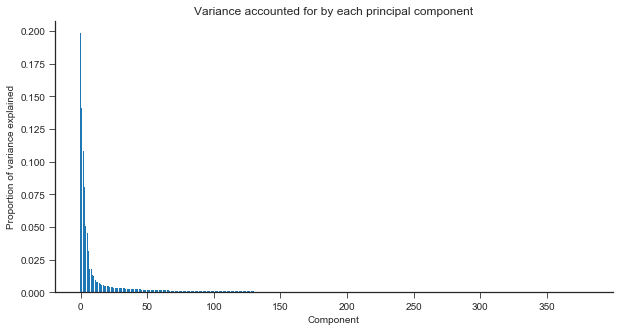

In [27]:
t.pca_variance_explained(pca)

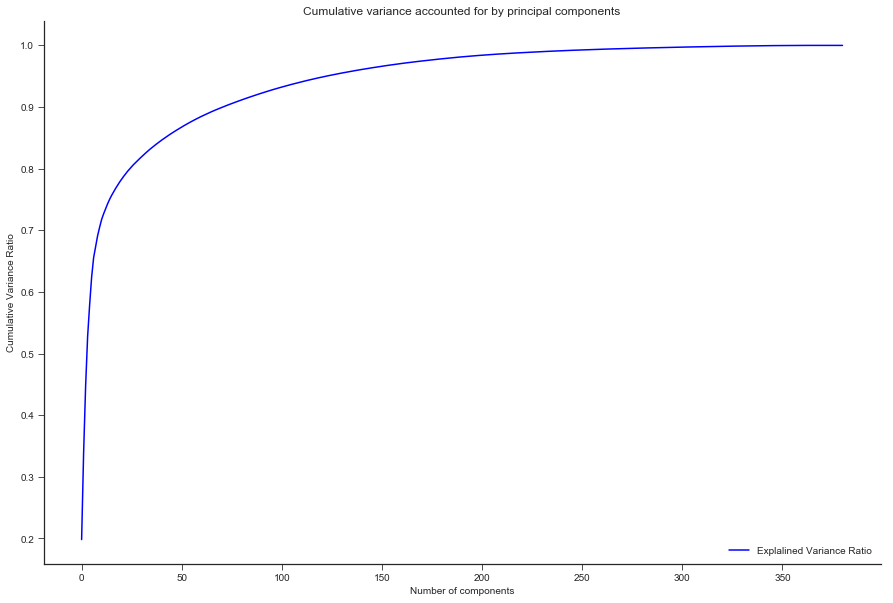

In [28]:
y1 = t.scree_plot(pca)

In [29]:
threshold = 0.92
number_components = int(np.argwhere(y1>=threshold)[1])
print("We retain {} components for analysis because they explain {}% of the variance in the data." 
      .format(number_components, int(threshold*100)))

We retain 89 components for analysis because they explain 92% of the variance in the data.


In [30]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=number_components)
azdias_PCA = pd.DataFrame(pca.fit_transform(azdias))
azdias_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,-0.509995,-10.716734,-3.546897,11.327849,-4.172764,3.523194,5.663546,-0.675599,-2.888190,1.448159,...,0.243908,-0.749319,-0.761108,-0.399327,0.425608,-1.170153,-0.375805,0.954708,-0.492145,0.050573
1,9.000664,-6.640804,2.994374,2.811965,-3.736245,-7.677771,7.613512,6.274449,-1.457306,-2.826374,...,0.336064,2.962840,0.053509,0.100796,1.552590,0.290324,-0.235838,-0.539616,0.107771,-2.287456
2,-8.743278,29.132958,-8.423643,14.702505,-2.579482,-11.621802,3.983968,5.967174,-5.501312,0.031553,...,1.176549,-0.819056,0.834692,-0.802054,-1.659828,0.896762,-0.039951,0.774962,-0.878975,-0.412451
3,-18.278069,12.532355,7.846892,14.805884,2.499025,-3.501783,-1.663410,4.212207,-2.877110,2.600864,...,0.108324,0.016125,0.540309,0.048629,-0.036665,1.244359,-1.547672,0.741077,-0.392547,-0.784591
4,-3.300591,-1.125818,-2.403280,-19.231740,-7.580419,9.093023,-0.216251,1.547694,4.108965,-2.882805,...,0.056910,-0.147084,1.114085,-0.386516,-1.488687,0.900557,0.052154,3.138181,0.675388,1.038087


I decided to retain 89 components for the rest of the analysis, because they explain 92% of the variance in the data. I found this particularly interesting, that about 25% of the variables in the dataset explained almost all of the variance in the data.

In [31]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(t.pca_results(pca, 1, columns=list(azdias.columns)))

EXTSEL992                     -0.855372
VK_ZG11                       -0.122053
VK_DISTANZ                    -0.119640
D19_VERSAND_ONLINE_QUOTE_12    0.078282
D19_GESAMT_ONLINE_QUOTE_12     0.082892
ANZ_STATISTISCHE_HAUSHALTE     0.395828
Name: 1, dtype: float64


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

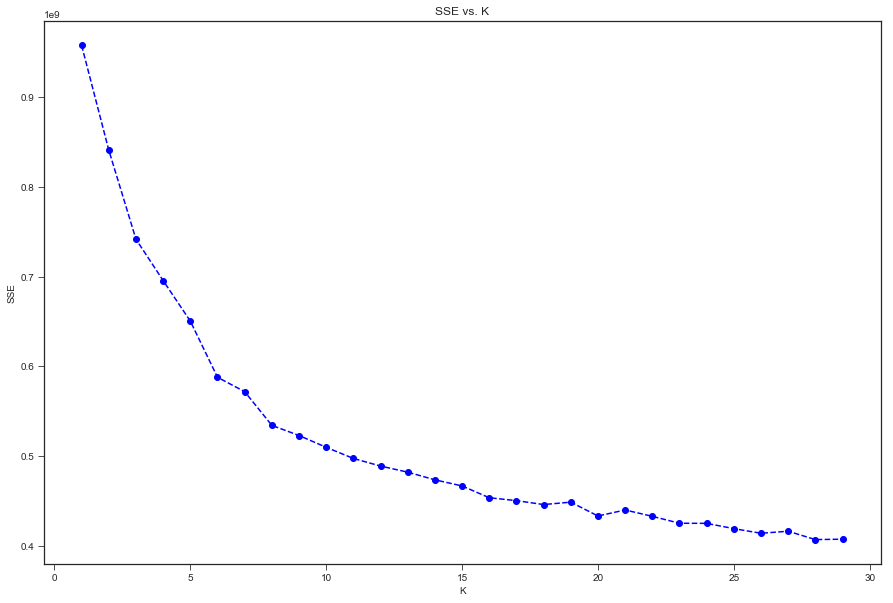

In [32]:
t.scree_plot_clusters(azdias_PCA, max_centers=30)

There appears to be an elbow at K=15 clusters, so I will segment the population into 15 clusters.

In [33]:
n_clusters = 15
kmeans = KMeans(n_clusters = n_clusters, random_state=SEED)
azdias_clusters = kmeans.fit_predict(azdias_PCA);

### Analysing Customer Data

It's now time to see how the customer data maps on to the clusters from the general population. I will use the fits from the general population to clean, transform, and cluster the customer dataand then interpret how the general population fits apply to the customer data.

In [34]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_052018.csv", sep=";", dtype = {18: 'str', 19: 'str'})

#Clean the customer demographics data.
clean_customers = t.clean_data(customers, feat_info)

Drop LNR and D19_LETZTER_KAUF_BRANCHE columns
Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done
Change EINGEFUEGT_AM to year
Log transforming skewed numerical features...
Log transforming skewed numerical features done
Scaling numerical features..
Scaling numerical features done


In [35]:
customers_PCA = pd.DataFrame(pca.transform(clean_customers), columns = list(azdias_PCA));
customer_clusters = kmeans.predict(customers_PCA);

### Step 3.3: Compare Customer Data to Demographics Data

Here, I compare the two cluster distributions to see where the strongest customer base for the company is.

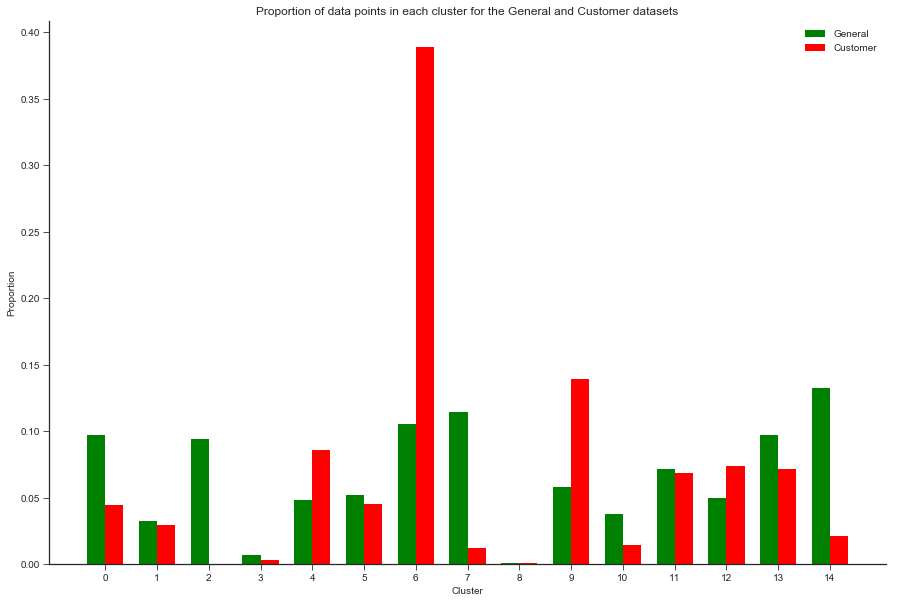

In [36]:
n_general = []
n_customer = []
for i in range(n_clusters):
    n_general.append(np.argwhere(azdias_clusters==i).shape[0]/azdias_clusters.shape[0])
    n_customer.append(np.argwhere(customer_clusters==i).shape[0]/customer_clusters.shape[0])

# A dataframe with the proportion of data in each cluster for the customer data 
# and the general population
label_counts = pd.DataFrame({'General Dataset': n_general})
label_counts['Customer Dataset'] = pd.Series(n_customer)
label_counts['Clusters'] = pd.Series(list(range(n_clusters)))

# Plotting bar chart to visualize these proportions
customer_props = label_counts['Customer Dataset']
general_props = label_counts['General Dataset']

ind = np.arange(n_clusters) 
width = 0.35 

plt.figure(figsize=(15,10))
plt.bar(ind, general_props, width, color='green', label='General')
plt.bar(ind + width, customer_props, width, color='red',
    label='Customer')

plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.title('Proportion of data points in each cluster for the General and Customer datasets')

plt.xticks(ind + width / 2, range(n_clusters))
plt.legend(loc='best')
sns.despine()
plt.show()

In [37]:
customers_PCA['labels'] = customer_clusters

In [42]:
over_represented_cluster = 6 # which cluster has an over-representation of customers?
under_represented_cluster = 7 # which cluster has an under-representation of customers?

#Get the rows corresponding to the sets identified above
over_rprsntd_ind = customers_PCA[customers_PCA.labels==over_represented_cluster].index
under_rprsntd_ind = customers_PCA[customers_PCA.labels==under_represented_cluster].index

#Now go to the customer dataset and find the corresponding subsets
over_rprsntd = clean_customers.loc[over_rprsntd_ind, :]
under_rprsntd = clean_customers.loc[under_rprsntd_ind, :]

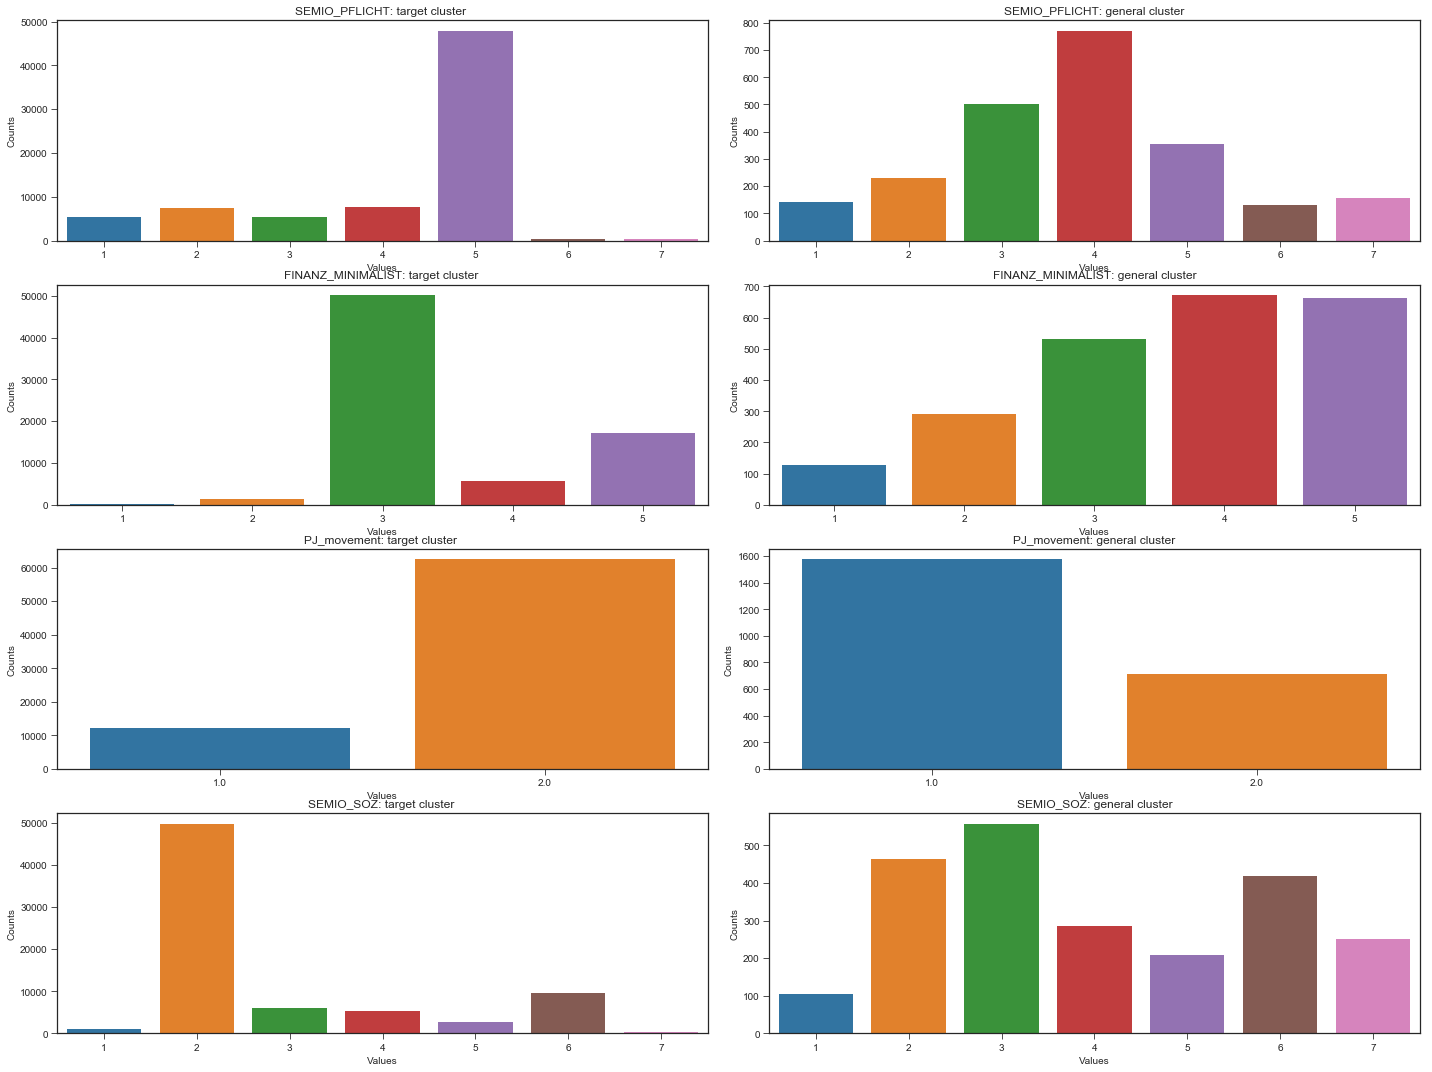

In [43]:
t.compare_distribution(['SEMIO_PFLICHT',
                        'FINANZ_MINIMALIST', 
                        'PJ_movement',
                        'SEMIO_SOZ'], 
                        over_rprsntd, 
                       under_rprsntd,
                      "target cluster", 
                      "general cluster")

### Compare Customer Data to Demographics Data

There are more than 300 features in the dataset. As such it would be virtually impossible to compare both populations exhaustively. However, I selected four features and compared both populations, just for illustrative purposes. The four features I selected are:

* `SEMIO-PFLICHT`: How dutiful the person is, with high values indicating low affinity for duty
* `FINANZ-MINIMALIST`: How low their financial interest is, with high values indicating low affinity
* `PJ-Movement`: Predominant movement of a person's youth
* `SEMIO-SOZ`: How socially minded the person is, with high values indicating low affinity

From the charts above, we can see that the target population is less dutiful, has a lower financial interest, and has a higher social affinity than the general population. The dominating movement of their youth is is Avantgarde, compared to the Mainstream movement for the general population.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype = {18:'str', 19:'str'})

response = mailout_train["RESPONSE"]

mailout_train = t.clean_data(mailout_train, feat_info)

Drop LNR and D19_LETZTER_KAUF_BRANCHE columns
Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done
Change EINGEFUEGT_AM to year
Log transforming skewed numerical features...
Log transforming skewed numerical features done
Scaling numerical features..
Scaling numerical features done


In [6]:
mailout_train.drop('RESPONSE', axis=1, inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mailout_train,
                                                   response,
                                                   test_size=0.2,
                                                   random_state=0)

I'm going to use a stacked model for this part of the project. To do this, I will use the [mlens library](http://ml-ensemble.com/). My strategy would be to optimise a series of base learners, and then use a super learner to get the final probabilities.

To tune the hyperparameters for each model, I use the `hyperopt` library, which I learnt to use using the tutorials [here](https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt) and [here](http://steventhornton.ca/hyperparameter-tuning-with-hyperopt-in-python/)

### Optimising Base Learners

#### Objective function

We have to define an objective function to minimize. Because we are interested in maximizing the ROC-AUC score, we will minimize 1-AUC.

In [18]:
def objective(params):
    pipe.set_params(**params)
    shuffle = StratifiedKFold(n_splits=5, shuffle=True)
    score = cross_val_score(pipe, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)
    return 1-score.mean()

#### Logistic Regression

In [22]:
lr = LogisticRegression(random_state=SEED, max_iter=4000, solver='lbfgs')

# Parameter search space
space = {}

pipe = Pipeline([('clf', lr)])
            
# Integer between 1 and 50
space['clf__C'] = hp.choice('clf__C', [0.001, 0.01, 0.1, 1, 10, 100])


# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best_lr = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params_lr = space_eval(space, best_lr)

# Fit the model with the optimal hyperparamters
pipe.set_params(**best_params_lr)
pipe.fit(X_train, y_train);

# Score with the test data
y_score = pipe.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print(auc_score)

0.7132777032721078


In [23]:
best_params_lr

{'clf__C': 0.01}

#### Random Forest

In [45]:
rf = RandomForestClassifier(random_state=SEED)

# Parameter search space
space = {}

pipe = Pipeline([('clf', rf)])
            
# Integer between 1 and 50
space['clf__bootstrap'] = hp.choice('clf__bootstrap', [True, False])
space['clf__max_depth'] = hp.choice('clf__max_depth', range(1,20))
space['clf__max_features'] = hp.choice('clf__max_features', range(1,11))
space['clf__criterion'] = hp.choice('clf__criterion', ["gini", "entropy"])
space['clf__n_estimators'] = hp.choice('clf__n_estimators', range(100,2000))
space['clf__class_weight'] = hp.choice('clf__class_weight', [{0:75},{0:76},{0:77},{0:78},{0:79},
                                                             {0:80},{0:81},{0:82},{0:83},{0:84}, {0:85}])
space['clf__min_samples_leaf'] = hp.choice('clf__min_samples_leaf', range(2,20))
space['clf__min_samples_split'] = hp.choice('clf__min_samples_split', range(2,10))


# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best_rf = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best_rf)

# Fit the model with the optimal hyperparamters
pipe.set_params(**best_params)
pipe.fit(X_train, y_train);

# Score with the test data
y_score = pipe.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print(auc_score)
print(best_params)

0.725022540482253
{'clf__bootstrap': False, 'clf__class_weight': {0: 79}, 'clf__criterion': 'entropy', 'clf__max_depth': 16, 'clf__max_features': 10, 'clf__min_samples_leaf': 17, 'clf__min_samples_split': 9, 'clf__n_estimators': 559}


#### Gradient Boosting Classifier

In [19]:
gb = GradientBoostingClassifier(random_state=SEED)

params = {'n_estimators': [20, 50, 100, 150], 
         'learning_rate': [0.01, 0.1, 1]}

grid_obj = RandomizedSearchCV(gb, params, scoring='roc_auc', cv=5)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_gb = grid_fit.best_estimator_

# Make predictions using the unoptimized  model
best_predictions = best_gb.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, best_predictions)
print(auc_score)
print(best_gb)


0.8076951394111838
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


#### LGBM Classifier

In [42]:
reg = lgb.LGBMClassifier(random_state=SEED)

# Parameter search space
space = {}

pipe = Pipeline([('clf', reg)])

            
# Integer between 1 and 50
space['clf__n_estimators'] = hp.choice('clf__n_estimators', range(100,1000))
space['clf__learning_rate'] = hp.choice('clf__learning_rate', [0.001, 0.005, 0.01, 0.1, 1])
space['clf__max_depth'] = hp.choice('clf__max_depth', range(2,30))
space['clf__num_leaves'] = hp.choice('clf__num_leaves', range(2,50))
space['clf__min_data_in_leaf'] = hp.choice('clf__min_data_in_leaf', range(2,10))


# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best_reg = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params = space_eval(space, best_reg)

# Fit the model with the optimal hyperparamters
pipe.set_params(**best_params)
pipe.fit(X_train, y_train);

# Score with the test data
y_score = pipe.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print(auc_score)
print(best_params)

0.8123295305236641
{'clf__learning_rate': 0.005, 'clf__max_depth': 19, 'clf__min_data_in_leaf': 3, 'clf__n_estimators': 425, 'clf__num_leaves': 11}


#### Multi-Layer Perceptron

In [26]:
nn = MLPClassifier(random_state=SEED)

# Parameter search space
space = {}

pipe = Pipeline([('clf', nn)])
            
# Integer between 1 and 50
space['clf__hidden_layer_sizes'] = hp.choice('clf__hidden_layer_sizes', [(50,50,50), (80, 20), (70,30,10)] )
space['clf__activation'] = hp.choice('clf__activation', ['tanh', 'relu'])
space['clf__solver'] = hp.choice('clf__solver', ['sgd', 'adam'])
space['clf__learning_rate'] = hp.choice('clf__learning_rate', ['constant', 'adaptive'])


# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best_nn = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best_params_nn = space_eval(space, best_nn)

# Fit the model with the optimal hyperparamters
pipe.set_params(**best_params_nn)
pipe.fit(X_train, y_train);

# Score with the test data
y_score = pipe.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_score[:,1])
print(auc_score)
print(best_params_nn)

0.6964504970232971
{'clf__activation': 'relu', 'clf__hidden_layer_sizes': (70, 30, 10), 'clf__learning_rate': 'adaptive', 'clf__solver': 'adam'}


At this point, I test each of the base classifiers to get their ROC AUC scores

In [40]:
nb = GaussianNB()
rf = RandomForestClassifier(bootstrap=False,
                             class_weight={0: 80}, 
                             criterion='entropy',
                             max_depth=2,
                             min_samples_leaf=8,
                             min_samples_split=2,
                             n_estimators=1000,
                             random_state=42)

gb = GradientBoostingClassifier(n_estimators=100,
                                    learning_rate=0.1,
                                    random_state=SEED)

reg = lgb.LGBMClassifier(random_state=SEED,
                        learning_rate=0.001,
                        max_depth=16,
                        min_data_in_leaf=2,
                        n_estimators=589, 
                        num_leaves=47)

nn = MLPClassifier(learning_rate = 'adaptive',
                   early_stopping=False,
                   activation='relu',
                   hidden_layer_sizes = (70, 30, 10),
                   solver = 'adam',
                   random_state=SEED)

lr = LogisticRegression(C=0.01,
                        random_state=SEED,
                        solver='lbfgs', 
                        max_iter=4000)

predictions_nb = (rf.fit(X_train, y_train)).predict_proba(X_test)[:,1]
predictions_rf = (rf.fit(X_train, y_train)).predict_proba(X_test)[:,1]
predictions_gb = (gb.fit(X_train, y_train)).predict_proba(X_test)[:,1]
predictions_reg = (reg.fit(X_train, y_train)).predict_proba(X_test)[:,1]
predictions_nn = (nn.fit(X_train, y_train)).predict_proba(X_test)[:,1]
predictions_lr = (lr.fit(X_train, y_train)).predict_proba(X_test)[:,1]

print("The following are the ROC AUC scores for the various base learners:\n")
print("Gaussian Naive Bayes: {} \n".format(roc_auc_score(y_test, predictions_nb)))
print("Random Forest: {} \n".format(roc_auc_score(y_test, predictions_rf)))
print("Gradient Boosting: {} \n".format(roc_auc_score(y_test, predictions_gb)))
print("LightGBM Classifier: {} \n".format(roc_auc_score(y_test, predictions_reg)))
print("Multi-Layer Perceptron: {} \n".format(roc_auc_score(y_test, predictions_nn)))
print("Logistic Regression: {} \n".format(roc_auc_score(y_test, predictions_lr)))

The following are the ROC AUC scores for the various base learners:

Gaussian Naive Bayes: 0.7483734606776189 

Random Forest: 0.7483734606776189 

Gradient Boosting: 0.7924259448879545 

LightGBM Classifier: 0.806769733682503 

Multi-Layer Perceptron: 0.6964504970232971 

Logistic Regression: 0.7132777032721078 



## Stacked Model

In [8]:
def get_models(SEED):
    """Generate a library of base learners."""
    nb = GaussianNB()
    lr = LogisticRegression(C=0.01, random_state=SEED, solver='lbfgs', max_iter=4000)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(
                            n_estimators=100,
                            loss="exponential",
                            max_depth=3,
                            subsample=0.5,
                            learning_rate=0.1, 
                            random_state=SEED
                            )
    reg = lgb.LGBMClassifier(random_state=SEED,
                             learning_rate=0.001,
                             max_depth=10, 
                             n_estimators=500
                            )
    rf = RandomForestClassifier(bootstrap=False,
                             class_weight={0: 80}, 
                             criterion='entropy',
                             max_depth=2,
                             min_samples_leaf=8,
                             min_samples_split=2,
                             n_estimators=1000,
                             random_state=SEED)

    models = {'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
               'lgbm': reg
              }

    return models



meta_learner = GradientBoostingClassifier(
    n_estimators=100,
    loss="exponential",
    max_depth=3,
    subsample=0.5,
    learning_rate=0.1, 
    random_state=SEED
)


preds = []
for SEED in range(15):
    print(SEED)
    base_learners = get_models(SEED)

    sl = SuperLearner(
        folds=10,
        random_state=SEED,
        verbose=0,
        backend="multiprocessing"
    )

    # Add the base learners and the meta learner
    sl.add(list(base_learners.values()), proba=True) 
    sl.add_meta(meta_learner, proba=True)

    predictions = (sl.fit(X_train, y_train)).predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, predictions)
    preds.append(score)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [16]:
print("The model had an average ROC AUC score of {:.4f}, with a variance of {:.4e}".format(np.mean(preds), 
                                                                                           np.var(preds)))

The model had an average ROC AUC score of 0.8147, with a variance of 3.0227e-05


Now I fit the model on the entire dataset, for use in the kaggle competition

In [ ]:
#sl.fit(mailout_train, response)

#saving the model to a file

filename = 'finalized_model.sav'
pickle.dump(sl, open(filename, 'wb'))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [5]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype = {18:'str', 19:'str'})

In [6]:
mailout_test.shape

(42833, 366)

In [7]:
mailout_test = t.clean_data(mailout_test, feat_info)

Drop LNR and D19_LETZTER_KAUF_BRANCHE columns
Drop columns with more than 20% missing values
Drop rows with more than 25 missing values
Re-encode 'OST_WEST_KZ'
Imputing missing values for features
One-hot encoding of categorical variables
Re-encoding categorical features done.
Engineering mixed-type features
Engineering mixed-type features done
Change EINGEFUEGT_AM to year
Log transforming skewed numerical features...
Log transforming skewed numerical features done
Scaling numerical features..
Scaling numerical features done


In [8]:
mailout_test.shape

(42833, 381)

In [9]:
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
kaggle_prediction = loaded_model.predict_proba(mailout_test)[:,1]


Predicting 2 layers
Processing layer-1             done | 00:00:06
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:08


In [10]:
submission = pd.read_csv('Arvato_Capstone_Example_Submission.csv')
submission.RESPONSE = kaggle_prediction
submission.to_csv('kaggle_submission.csv', index=False)
submission.shape

(42833, 2)